# CAPTCHA IMAGE PROJECT

## Imports and downloading datasets

In [ ]:
!pip install pytesseract pillow opencv-python

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from PIL import Image, ImageDraw
import string
from torch.nn.functional import one_hot
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
# !rm -r cifar-10-python.tar.gz.1
# !rm -r cifar-10-batches-py
# !rm -r data

In [73]:
#### DOWNLOAD THE DATASET ####
if not os.path.exists('./cifar-10-python.tar.gz'):
  !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  !mkdir ./data
  !tar -xzvf cifar-10-python.tar.gz -C ./data
  !mv ./data/cifar-10-batches-py/* ./data/
  !rmdir ./data/cifar-10-batches-py

In [74]:
# from google.colab import files
if not os.path.exists('captcha-version-2-images.zip'):
  !pip install -q kaggle
  files.upload()
# !ls -lha kaggle.json
  !mkdir -p ~/.kaggle

  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle datasets download -d fournierp/captcha-version-2-images

In [75]:
# Check if the dataset zip file doesn't exist
if not os.path.exists('captcha-version-2-images.zip'):
    !pip install -q kaggle

    # Create the kaggle directory and copy the kaggle.json file into it
    !mkdir -p ~/.kaggle
    !cp ./kaggle/kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset
    !kaggle datasets download -d fournierp/captcha-version-2-images
    !unzip -q captcha-version-2-images.zip

# Load Datasets and example image extraction

## Captcha Dataset

In [81]:
class CaptchaDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
      self.data = torch.from_numpy(numpy_data).float()
      self.labels = torch.from_numpy(numpy_labels).float()
      self.transform = transform
      # breakpoint()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label


In [82]:
#### LOADING THE DATASET INTO A DICTIONARY ####
def unpickle(file):
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

train_batches = [unpickle(f'data/data_batch_{num}') for num in range(1, 6)]
test_batch = unpickle('data/test_batch')
meta_data = unpickle('data/batches.meta')

#### FORMAT OF THE BATCHES ####
# {
#     b'batch_label': 'training batch x of 5',
#     b'labels' : [numerical labels for each photo (1-9)],
#     b'data': [[]] <- this is an array of all of the photos
#     b'filenames': [array of every filename]
# }

#### FORMAT OF THE META DATA ####
# {
#     b'num_cases_per_batch' : 10000,
#     b'label_names': [array of each label name indexed from 0-9]
#     b'num_vis': 3072
# }

#### SHOW THE CORRESPONDING TEXT LABEL FOR EACH INTEGER ####
meta_data[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

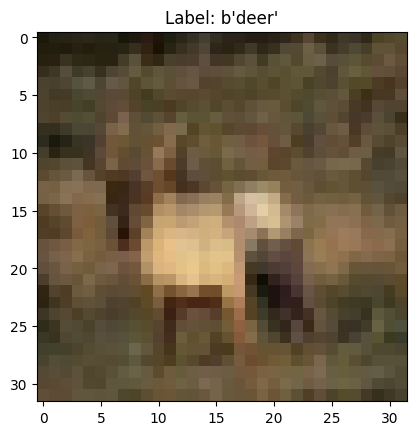

In [83]:
#### EXAMPLE OF GETTING AN IMAGE OUT ####
images = train_batches[0][b'data']
numerical_labels = train_batches[0][b'labels']
text_label_interpretations = meta_data[b'label_names']

test_image = images[3]
numerical_label = numerical_labels[3]
# The images are flattened into a 1 x 3072 array so test_image is useless as-is
# we first need to reshape them into a 32 x 32 x 3 tensor (a 32 x 32 image with RGB channels)
# then we actually need to swap the 0 and the 1 index (the pics are sideways)
image_reshaped = np.reshape(test_image, (32, 32, 3), order='F')
image_reshaped = np.swapaxes(image_reshaped, 0, 1)

#### NOTE THAT THE QUALITY OF THE IMAGES SUUUUUCKS ####
plt.imshow(image_reshaped)
plt.title(f"Label: {text_label_interpretations[numerical_label]}")
plt.show()

# Create Simulated Captchas

The images are already shuffled pretty well, so make the 3x3 grids is just to take 9 images in a row and concatenate them together to make the grids.

Example in the next cell.

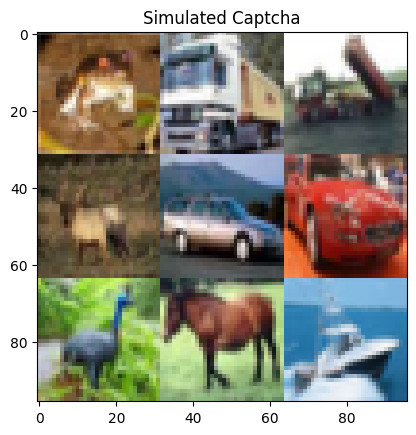

[[b'frog' b'truck' b'truck']
 [b'deer' b'automobile' b'automobile']
 [b'bird' b'horse' b'ship']]


In [84]:
#### MAKE A SIMULATED CAPTCHA ####
captcha_unshaped = [image for image in images[:9]]
captcha_reshaped = [np.reshape(unshaped, (32, 32, 3), order='F') for unshaped in captcha_unshaped]
captcha_oriented = [np.swapaxes(image_reshaped, 0, 1) for image_reshaped in captcha_reshaped]

captcha = np.reshape(captcha_oriented, (3, 3, 32, 32, 3)).transpose(0, 2, 1, 3, 4).reshape(96, 96, 3)

plt.imshow(captcha)
plt.title("Simulated Captcha")
plt.show()

#### BY RESHAPING I MATCH THE INT LABELS TO THE SAME FORMAT AS THE CAPTCHA ####
int_labels = np.array([label for label in numerical_labels[:9]]).reshape(3, 3)
text_labels = np.array([text_label_interpretations[index] for row in int_labels for index in row]).reshape(3,3)
#### THE TEXT LABELS ARE PRINTED DIRECTLY BENEATH THE CAPTCHA IN THE SAME ORDER AS THE CAPTCHA ####
print(text_labels)

In [85]:
def create_simulated_captchas(batch, text_labels, test=False):
  captchas = []
  captcha_numerical_labels = []
  captcha_text_labels = []
  images = batch[b'data']
  label_indeces = batch[b'labels']

  ##############################
  # This scrambling essentially quintuples the amount of captchas that we have. it only works because
  # the captchas will be unique even if they are the same images in a different order
  # I added the test boolean thing because 5xing the test dataset doesn't really help us, it just makes eval slower

  # quintuple the data and labels
  if not test:
    duplicated_images = np.concatenate([images] * 40, axis=0)
    duplicated_label_indeces = np.concatenate([label_indeces] * 40, axis=0)

    # Generate a random permutation index
    permutation = np.random.permutation(len(duplicated_images))

    # Shuffle both the data and labels using the same permutation index
    shuffled_images = duplicated_images[permutation]
    shuffled_label_indeces = duplicated_label_indeces[permutation]
  else:
    shuffled_images = images
    shuffled_label_indeces = label_indeces
  ##############################

  # the amount of images does not perfectly divide by 9, so at some point
  # we will not have enough images left to make a new captcha.
  # when that happens we will break out of the loop
  while(len(shuffled_images) >= 9):
    captcha_unshaped = [image for image in shuffled_images[:9]]
    captcha_reshaped = [np.reshape(unshaped, (32, 32, 3), order='F') for unshaped in captcha_unshaped]
    captcha_oriented = [np.swapaxes(image_reshaped, 0, 1) for image_reshaped in captcha_reshaped]

    captcha = np.reshape(captcha_oriented, (3, 3, 32, 32, 3)).transpose(0, 2, 1, 3, 4).reshape(96, 96, 3)

    # int_labels = np.array([label for label in label_indeces[:9]]).reshape(3, 3)
    int_labels = np.array([label for label in shuffled_label_indeces[:9]])
    # human_labels = np.array([text_labels[index] for row in int_labels for index in row]).reshape(3,3)
    human_labels = np.array([text_labels[index] for index in int_labels])
    captchas.append(captcha)
    captcha_numerical_labels.append(int_labels)
    captcha_text_labels.append(human_labels)

    # this little bit deletes the images that we have already used from the data so we don't reuse photos
    shuffled_images = shuffled_images[9:]
    shuffled_label_indeces = shuffled_label_indeces[9:]

  return np.array(captchas), captcha_numerical_labels, captcha_text_labels

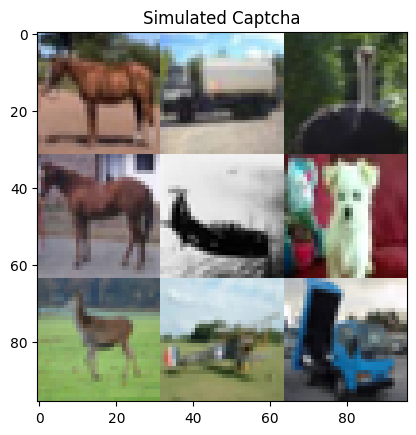

[b'horse' b'truck' b'bird' b'horse' b'airplane' b'dog' b'deer' b'airplane'
 b'truck']


In [86]:
### THIS CREATES ALL OF THE SIMULATED CAPTCHAS ###
concatenated_results = [create_simulated_captchas(batch, text_label_interpretations) for batch in train_batches]
captchas, num_labels, text_labels = [np.concatenate([t[i] for t in concatenated_results]) for i in range(3)]

test__image_captchas, test_num_labels, test_text_labels = create_simulated_captchas(test_batch, text_label_interpretations, True)
for label, captcha in zip(text_labels[1302:1303], captchas[1302:1303]):
  plt.imshow(captcha)
  plt.title("Simulated Captcha")
  plt.show()
  print(label)

# Image Captcha Model Work

With the simulated captchas created, we have two options. We can either make a resnet or some kind of classifier that outputs a 3 x 3 x 9 tensor of predictions (9 probabilities for each of the images in the 3 x 3 grid),

_OR_ we can split the captcha back into individual images _before_ we put it into the classifier, get the probabilities for each image separately, and then concatenate them all back together to display the output.

---
  
Note that we already have our data formatted in

captchas : (array of 96x96x3 images)

num_labels : (1x9 arrays with the correct numerical labels for each captcha)

text_labels : (human readable labels in a 3x3 grid for each captcha)

test_image_captchas, test_num_labels, and test_text_labels are exactly what they sound like they are. all of the above except for testing.

## Full Captcha Prediction (no splitting)

### Model Class Definition

In [87]:
class Full_Captcha_Predictor(nn.Module):
    def __init__(self, num_sections, num_classes, start_frozen=False):
        super(Full_Captcha_Predictor, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        if start_frozen:
            for param in self.model.parameters():
              param.requires_grad = False

        # Remove the original fully connected layer
        self.model.fc = nn.Identity()
        # Add a new fully connected layer for each section
        self.fc_sections = nn.ModuleList([nn.Linear(2048, num_classes, bias=True) for _ in range(num_sections)])

    def unfreeze(self, n_layers):
      for num, (name, param) in enumerate(self.model.named_parameters()):
        if num >= n_layers:
          param.requires_grad = True

    def forward(self, x):
      x = self.model(x)
      # Forward pass through each section's fully connected layer
      section_outputs = [fc(x) for fc in self.fc_sections]
      return section_outputs

    def eval(self):
      self.model.eval()

    def train(self):
      self.model.train()

### Testing Defaults

This part is testing the default resnet with default pretrained weights. You can ignore it

In [88]:
# This is just a test of classification with the default resnet50 imagenet1k_v2 weights
weights = models.ResNet50_Weights.IMAGENET1K_V2
full_captcha_predictor = models.resnet50(weights=weights)

full_captcha_predictor.eval() # This puts the model in inference mode, call .train() to train

t = torch.tensor(image_reshaped, dtype=torch.float32)
t = t.unsqueeze(0)
t = t.permute(0, 3, 1, 2)
prediction = full_captcha_predictor(t).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(category_name, score)
# It sucks... it is supposed to be a truck

projector 1.0


This part is testing default untrained full prediction model, it was just to make sure the shapes worked out and that we could run inference the way we want to.

In [89]:
### IMPORTANT WHEN RUNNING INFERENCE ###
# THE DEFAULT RESNET INPUT LAYERS EXPECT AN INPUT OF (BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH)
# IF YOU ARE GIVING ONE INDIVIDUAL IMAGE EX 32 X 32 X 3, YOU MUST FIRST UNSQUEEZE(0)
# THEN USE .PERMUTE(0, 3, 1, 2) TO MAKE IT THE RIGHT SHAPE
########################################
c = torch.tensor(captchas[0], dtype=torch.float32)
c = c.unsqueeze(0)
c = c.permute(0, 3, 1, 2)
captcha_test_model = Full_Captcha_Predictor(9, 10) # there are 9 sections that need predictions with 10 classes each
captcha_test_model.eval()
# predictions will be a tensor 9 x 10 x 1 (10 probabilities per prediction)
predictions = captcha_test_model(c)
# we change it from log probs to a softmaxed probabilities and squeeze extra dim
predictions = [prediction.squeeze(0).softmax(0) for prediction in predictions]
# instead of sampling we take the argmax
class_ids = [prediction.argmax().item() for prediction in predictions]
# get the scores for the argmax
scores = [prediction[id].item() for id, prediction in zip(class_ids, predictions)]
# map the argmaxes to human readable category names
category_names = [text_label_interpretations[class_id] for class_id in class_ids]
for category_name, score in zip(category_names, scores):
  print(category_name, score)

b'airplane' 0.9899099469184875
b'ship' 0.9999202489852905
b'truck' 0.9999982118606567
b'ship' 0.9998528957366943
b'ship' 0.9999963045120239
b'bird' 1.0
b'frog' 1.0
b'frog' 0.9999862909317017
b'automobile' 0.9997854828834534


### Training Code

In [90]:
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=2)
    preds = torch.eye(10)[preds.long().cpu()]
    preds = preds.to(device)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device):
    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() because we aren't looking for saving gradients here
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth
            x = x.permute(0, 3, 1, 2)
            one_hot_encoded = torch.eye(10)[y_truth.long()]
            y_truth = one_hot_encoded.to(device)
            y_hat = model(x)
            y_hat = torch.stack(y_hat).permute(1, 0, 2)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

    model.train() # put it back into train mode so the loop doesn't crash

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [91]:
### HYPERPARAMETERS ### my best ones so far are lr = .0001, batch=32, epochs=7, test_steps=868
lr = .002 # 00045
batch_size = 256
epochs = 4
test_steps = 867
unfreeze_every = 330 // 2
lr_step_size = 330 // 2
lr_gamma = 0.8
#######################

final_captcha = Full_Captcha_Predictor(9, 10, start_frozen=True).to(device)
final_captcha.train()
frozen_layers = len(list(final_captcha.model.named_parameters()))
optimizer = optim.Adam(final_captcha.parameters(), lr=lr, weight_decay=1e-2)
objective = nn.CrossEntropyLoss()

learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma) # gamma .8
captcha_dataset = CaptchaDataset(captchas, num_labels)
captcha_test_dataset = CaptchaDataset(np.array(test_image_captchas), np.array(test_num_labels))

train_dataloader = DataLoader(captcha_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(captcha_test_dataset)

losses = []
accs = []
val_losses = []
val_accs = []

total_steps = -1
acc = 0
for epoch in range(epochs):
  progress_bar = tqdm(train_dataloader, desc="Loss")
  for x, y_truth in progress_bar:
    x = x.to(device)
    x = x.permute(0, 3, 1, 2)
    # turn y_truth into a 3d tensor with one hot encoded values
    one_hot_encoded = torch.eye(10)[y_truth.long()]
    y_truth = one_hot_encoded.to(device)
    predictions = final_captcha(x)
    # predictions is a list of tensors, to make it comparable to the y_truth we must concatenate them with stack
    predictions = torch.stack(predictions).permute(1, 0, 2)
    train_acc = accuracy(predictions, y_truth).cpu().item()
    accs.append(train_acc)
    loss = objective(predictions, y_truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_steps += 1
    if total_steps % test_steps == 0:
      val_loss, val_acc = evaluate(final_captcha, objective, test_dataloader, device)
      val_losses.append(val_loss.item())
      val_accs.append(val_acc.cpu())
      acc = val_accs[-1].item()
    if total_steps != 0 and total_steps % unfreeze_every == 0:
      frozen_layers = frozen_layers - 10 if frozen_layers > 10 else 0
      final_captcha.unfreeze(frozen_layers)
    learning_rate_scheduler.step()
    progress_bar.set_description(f"Epoch: {epoch}\tLoss: {loss.item(): .4f}\tVal Accuracy: {acc: .4f}\t Train Accuracy: {train_acc: .4f}")

    losses.append(loss.item())

Epoch: 0	Loss:  0.9250	Val Accuracy:  0.9430	 Train Accuracy:  0.9515: 100%|██████████| 868/868 [01:33<00:00,  9.31it/s]
Epoch: 1	Loss:  0.5393	Val Accuracy:  0.9631	 Train Accuracy:  0.9944: 100%|██████████| 868/868 [01:46<00:00,  8.13it/s]
Epoch: 2	Loss:  0.4749	Val Accuracy:  0.9677	 Train Accuracy:  0.9993: 100%|██████████| 868/868 [02:17<00:00,  6.32it/s]
Epoch: 3	Loss:  0.4539	Val Accuracy:  0.9683	 Train Accuracy:  0.9999: 100%|██████████| 868/868 [02:38<00:00,  5.49it/s]


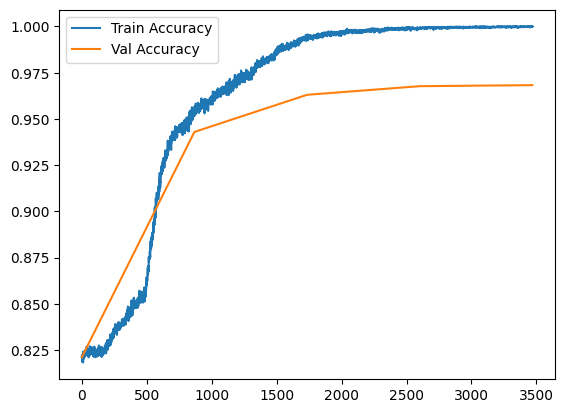

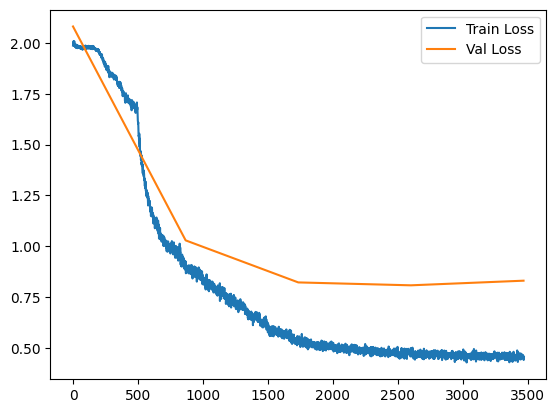

In [92]:
# plt.subplot(121)
plt.plot(np.arange(len(losses)), accs, label='Train Accuracy')
plt.plot(np.arange(len(losses)+2, step=test_steps), val_accs, label='Val Accuracy') # pretty sure this is not correct (see my above comment in the training loop)
# especially given that the random one we picked below gets like 70-80% accuracy and this plot shows 10% accuracy
plt.legend()
plt.show()
# plt.subplot(122)
plt.plot(np.arange(len(losses)), losses, label='Train Loss')
plt.plot(np.arange(len(losses)+2, step=test_steps), val_losses, label='Val Loss') # 13020 just makes it so that there are 15 spots for the 15 val_losses that we gathered
plt.legend()
plt.show()

Sam's Findings
- no difference in loss between resnet50 and 152 (haven't tested with latest hyperparameters)
- lowest loss achieved so far is .57 after 7 epochs (these parameters lr = .0001, batch_size = 128, epochs = 7)

array([[b'automobile', b'airplane', b'truck'],
       [b'cat', b'horse', b'truck'],
       [b'airplane', b'dog', b'truck']], dtype='|S10')

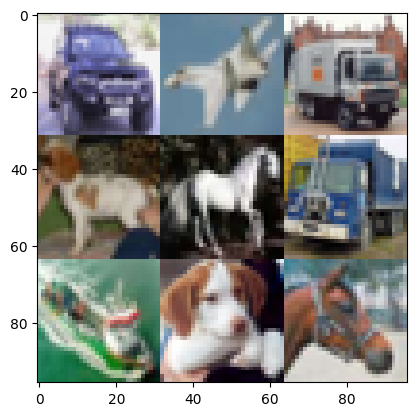

In [93]:
# This is just a quick example of a test captcha being passed through. the predicted labels are shown above the photo
final_captcha.eval() # put it in eval mode
test_cap, _ = captcha_test_dataset[1] # we don't need the true labels so _
plt.imshow(test_cap.int().numpy()) # it needs to be integer from float, and we are going to use numpy not torch tensor
test_cap = test_cap.unsqueeze(0).permute(0, 3, 1, 2).to(device) # gotta reorganize the dimensions

predictions = final_captcha(test_cap)
predicted_labels = [prediction.argmax().item() for prediction in predictions]
text_labels = [text_label_interpretations[label] for label in predicted_labels] # get the text predictions
text_labels = np.array(text_labels)
text_labels.reshape(3, 3) # reshape it so it looks like the captcha

### Demonstration

In [94]:
def demonstrate(model, image, truth, label_to_find, print_stuff=False):
    model.eval()
    im = image.int().cpu().numpy()
    image = image.unsqueeze(0).permute(0, 3, 1, 2).to(device)
    predictions = model(image)
    predicted_labels = [prediction.argmax().item() for prediction in predictions]
    text_labels = [text_label_interpretations[label] for label in predicted_labels]
    true_text_labels = [text_label_interpretations[label.int().item()] for label in truth]
    chosen_text = text_label_interpretations[label_to_find]

    correct_w_indeces = [(label == true_label, index % 3, index //3) for (index, label), true_label in zip(enumerate(predicted_labels), truth) if label == label_to_find]
    missed_w_indeces = [(index%3, index // 3) for (index, label), true_label in zip(enumerate(predicted_labels), truth) if label != label_to_find and true_label == label_to_find]
    plt.imshow(im)
    for correct, index, y_index in correct_w_indeces:
        if correct:
            plt.axvspan(xmin=index*31.666, xmax=95.666 - (32.333*(2 - index)), ymin=(2-y_index)*.3333, ymax=1 - (.3333*y_index), color='green', alpha=.7)
        else:
            plt.axvspan(xmin=index*31.666, xmax=95.666 - (32.333*(2 - index)), ymin=(2-y_index)*.3333, ymax=1 - (.3333*y_index), color='red', alpha=.7)
    for index, y_index in missed_w_indeces:
        plt.axvspan(xmin=index*31.666, xmax=95.666 - (32.333*(2 - index)), ymin=(2-y_index)*.3333, ymax=1 - (.3333*y_index), color='orange', alpha=.7)
    if print_stuff:
        text_labels = np.array(text_labels)
        text_labels = text_labels.reshape(3, 3)
        print("predicted:\n", text_labels)
        true_text_labels = np.array(true_text_labels)
        true_text_labels = true_text_labels.reshape(3, 3)
        print("truth:\n", true_text_labels)
    plt.title(f"Predicted: {chosen_text}")
    plt.show()

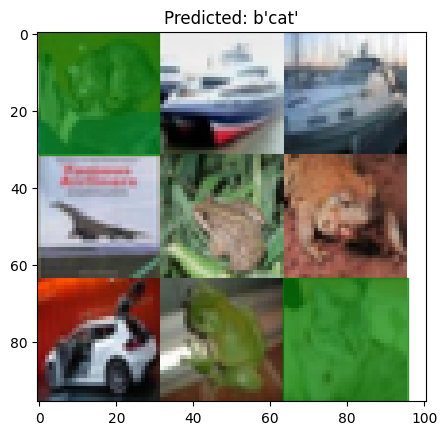

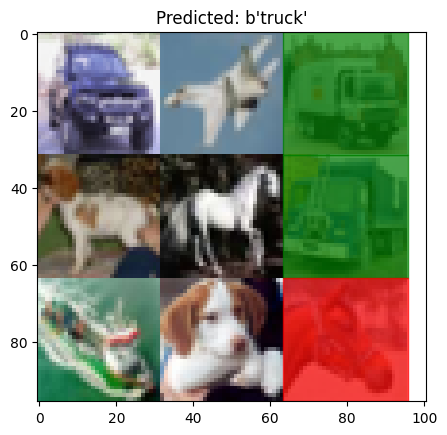

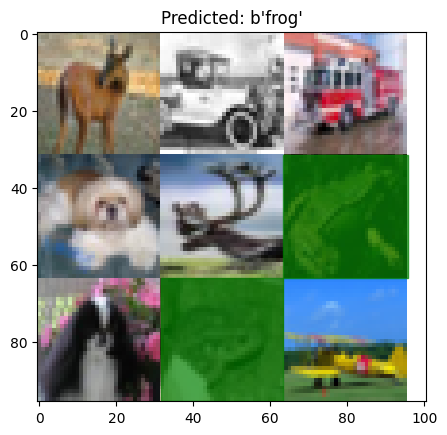

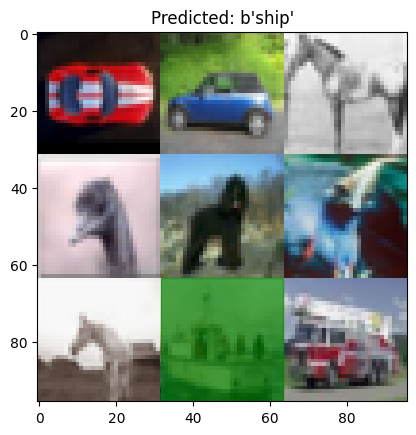

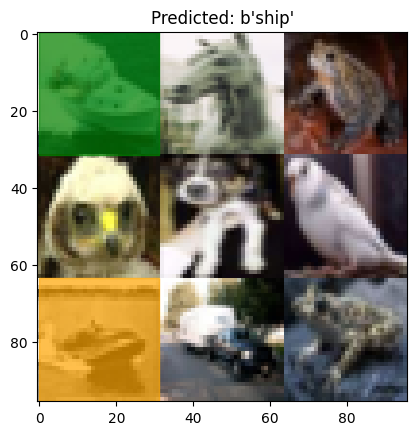

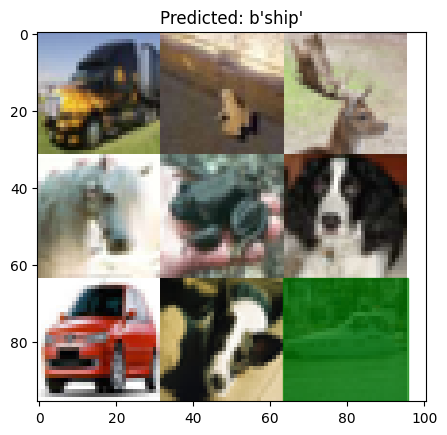

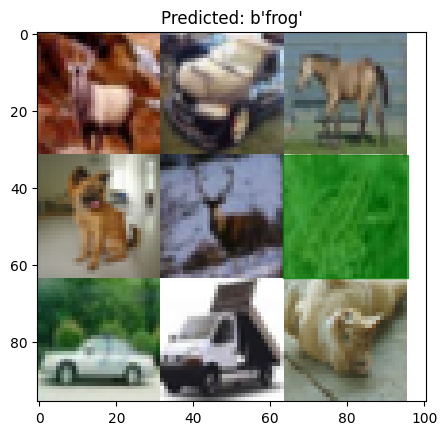

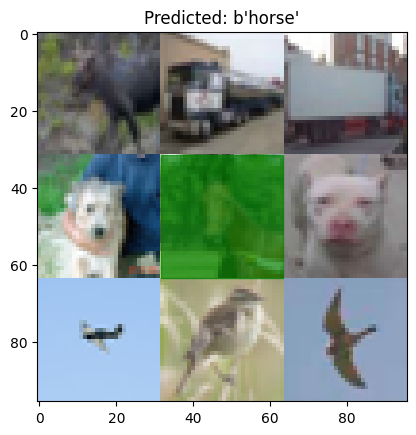

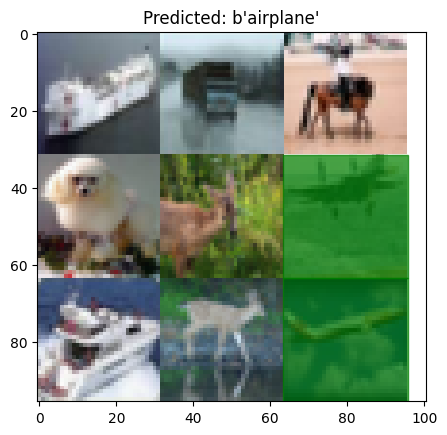

In [111]:
import random

for i in range(9):
    rand_index = random.randint(0,8)
    label_to_predict = captcha_test_dataset[i*i][1][rand_index].int().item()
    demonstrate(final_captcha, *captcha_test_dataset[i*i], label_to_predict)

## Splitting and reconcatenation prediction

In [96]:
### make a class for this model

In [97]:
#code for pretrained models from pytorch documentation:
# weights=models.ResNet50_Weights.IMAGENET1K_V2 #could also use default weights, or no specified weights

# full_captcha_predictor = models.resnet50(weights=weights)

# model.train()

# preprocess = weights.transforms()
# img_transformed = preprocess(img)

# batch = preprocess(img).unsqueeze(0)

# prediction = model(batch).squeeze(0).softmax(0)
# class_id = prediction.argmax().item()
# score = prediction[class_id].item()
# category_name = weights.meta["categories"][class_id]
# print(f"{category_name}: {100 * score}%")